In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import os
from tqdm import tqdm_notebook
from skimage.transform import resize
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [2]:
path = '/media/danil/Data/Datasets/CelebA/Img'
path_to_img = '/media/danil/Data/Datasets/CelebA/Img/img_align_celeba'

In [3]:
training = pd.read_csv(os.path.join(path,'list_attr_celeba.txt'), delimiter=" ")
training.Smiling = training.Smiling.map({1:1, -1:0})
training.head()

,ImageName,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,0,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,0,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,0,-1,-1,-1,-1,1,-1,-1,1


In [4]:
open_mouth_df = pd.read_csv(os.path.join(path,'CelebA.csv'))
open_mouth_df.columns = ['ImageName', 'open_mouth']
open_mouth_df.head()

,ImageName,open_mouth
0,055997.jpg,1
1,131827.jpg,1
2,052069.jpg,1
3,110305.jpg,1
4,098890.jpg,1


In [5]:
training = pd.merge(training, open_mouth_df, how='right', on='ImageName')
training.head()

,ImageName,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,open_mouth
0,000077.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,0
1,000090.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,1,-1,-1,-1,-1,-1,-1,1,0
2,000102.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,0,-1,-1,-1,-1,-1,-1,-1,1,0
3,000115.jpg,-1,-1,-1,-1,1,-1,-1,-1,-1,...,0,-1,-1,-1,-1,-1,-1,-1,-1,0
4,000149.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,1,-1,-1,-1,1,1


In [6]:
training.shape

(3724, 42)

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
X_train_cv = skf.split(training.values, training['Smiling'].values)

index_train_dict = {}
index_test_dict = {}
for i in range(5):
    ind = next(X_train_cv)
    index_train_dict['split_{}'.format(i)] = ind[0]
    index_test_dict['split_{}'.format(i)] = ind[1]

In [8]:
from sklearn.utils import shuffle
from imutils import face_utils
import imutils
import dlib
import cv2 as cv

In [106]:
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
def cascadeHaar(img):
    img = np.array(img, dtype=np.uint8)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    for face in faces:
        img = img[max(0,face[1]):max(0,face[1])+max(0,face[3]), max(0,face[0]):max(0,face[0])+max(0,face[2])]
        return img, 1
    return img, 0

import dlib
hog_face_detector = dlib.get_frontal_face_detector()
def hog_face_detection(img):
    faces_hog = hog_face_detector(img, 1)
    for face in faces_hog:
        img = img[max(0,face.top()):max(0,face.bottom()), max(0,face.left()):max(0,face.right())]
        return img, 1
    return img, 0

cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
def cnn_face_detection(img):
    faces_cnn = cnn_face_detector(img, 1)
    for face in faces_cnn:
        img = img[max(0,face.rect.top()):max(0,face.rect.bottom()), max(0,face.rect.left()):max(0,face.rect.right())]
        return img, 1
    return img, 0

from mtcnn.mtcnn import MTCNN
detector = MTCNN()
def mtcnn_detect(img):
    faces = detector.detect_faces(img)
    for face in faces:
        img = img[max(0,face['box'][1]):max(0,face['box'][1]) + max(0,face['box'][3]), 
                  max(0,face['box'][0]): max(0,face['box'][0]) + max(0,face['box'][2])]
        return img, 1
    return img, 0

def get_face(img):
    img, label = mtcnn_detect(img)
    if label==0:
        img, label = hog_face_detection(img)
        if label==0:
            img, label = cnn_face_detection(img)
            if label==0:
                img, label = cascadeHaar(img)
    return img, label

In [137]:
detector_points(gray, 1)

rectangles[[(46, 86) (135, 176)]]

In [144]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector_points = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

def get_points(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    rects = detector_points(gray, 1)
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        return shape[37:69]
    
def get_my_points(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    rects = detector.detect_faces(img)
    for rect in rects:
        r = dlib.rectangle(max(0,rect['box'][0]), max(0,rect['box'][1]), max(0,rect['box'][2]),
                           max(0,rect['box'][3]))
        shape = predictor(gray, r)
        shape = face_utils.shape_to_np(shape)
        return shape[37:69]

In [147]:
#training = training[training.index.isin(index_train_dict['split_0'])]
training = shuffle(training)
out_rgb = []
out_points = []
out_smile = []
out_mouth = []
for path_img, smile, open_mouth in tqdm_notebook(training[['ImageName', 'Smiling', 'open_mouth']].values[:]):
    img = imread(os.path.join(path_to_img, path_img))
    img, label = get_face(img)
    img = imutils.resize(img, width=256)
    out_rgb += [img]
    out_points += [get_my_points(img)]
    out_smile += [smile]
    out_mouth += [open_mouth]
    if out_points[-1] is None:
        out_rgb.pop()
        out_points.pop()
        out_smile.pop()
        out_mouth.pop()

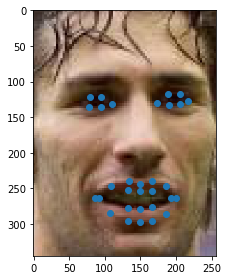

In [148]:
imshow(out_rgb[10])
plt.scatter(out_points[10][:,0], out_points[10][:,1])

# Build Model

In [209]:
import keras.backend as K
K.clear_session()

In [210]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [211]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

weight_path='landmark.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_f1', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=False)

reduceLROnPlat = ReduceLROnPlateau(monitor='f1', factor=0.1, patience=5, 
                                   verbose=1, mode='max', min_lr=0.0000001)

callbacks_list = [checkpoint, reduceLROnPlat]

In [220]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Input, Convolution1D, MaxPool1D, GlobalAveragePooling1D
from keras.optimizers import Adam

x = Input(shape=(31,2))
smile = Convolution1D(4, kernel_size=4, activation='relu', input_shape=(31,2))(x)
smile = MaxPool1D()(smile)
smile = BatchNormalization()(smile)
smile = Flatten()(smile)
smile = Dense(64, activation='relu')(smile)
smile = BatchNormalization()(smile)
smile = Dense(16, activation='relu')(smile)
smile = BatchNormalization()(smile)
smile = Dense(1, activation='sigmoid', name='smile')(smile)

mount = Convolution1D(4, kernel_size=4, activation='relu', input_shape=(31,2))(x)
mount = MaxPool1D()(mount)
mount = BatchNormalization()(mount)
mount = Flatten()(mount)
mount = Dense(64, activation='relu')(mount)
mount = BatchNormalization()(mount)
mount = Dense(16, activation='relu')(mount)
mount = BatchNormalization()(mount)
mount = Dense(1, activation='sigmoid', name='mouth')(mount)

model = Model(input = x, output = [smile, mount])

model.compile(loss = {'smile':"binary_crossentropy", 'mouth':"binary_crossentropy"}, 
                    optimizer = Adam(lr=0.001, decay=0.0001), 
                    metrics=[f1], 
                    loss_weights=[0.5, 0.5])

/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [221]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 31, 2)        0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 28, 4)        36          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 28, 4)        36          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 14, 4)        0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [222]:
weight_path='landmark.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_smile_f1', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=False)

reduceLROnPlat = ReduceLROnPlateau(monitor='f1', factor=0.1, patience=5, 
                                   verbose=1, mode='max', min_lr=0.0000001)

callbacks_list = [reduceLROnPlat, checkpoint]

In [223]:
model.fit(np.array(out_points), 
          [np.array(out_smile), np.array(out_mouth)],
          epochs=100, 
          batch_size=64, 
          validation_split=0.2, 
          callbacks=callbacks_list, verbose=2)

Train on 2344 samples, validate on 587 samples
Epoch 1/100
 - 2s - loss: 0.6065 - smile_loss: 0.5880 - mouth_loss: 0.6250 - smile_f1: 0.6703 - mouth_f1: 0.6674 - val_loss: 0.5277 - val_smile_loss: 0.4985 - val_mouth_loss: 0.5568 - val_smile_f1: 0.7877 - val_mouth_f1: 0.7382

Epoch 00001: val_smile_f1 improved from -inf to 0.78773, saving model to landmark.h5


/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `f1` which is not available. Available metrics are: smile_f1,lr,smile_loss,mouth_loss,loss,mouth_f1,val_smile_f1,val_mouth_f1,val_mouth_loss,val_smile_loss,val_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100
 - 0s - loss: 0.4565 - smile_loss: 0.4549 - mouth_loss: 0.4581 - smile_f1: 0.7923 - mouth_f1: 0.7781 - val_loss: 0.5009 - val_smile_loss: 0.5039 - val_mouth_loss: 0.4979 - val_smile_f1: 0.7127 - val_mouth_f1: 0.7629

Epoch 00002: val_smile_f1 did not improve from 0.78773
Epoch 3/100
 - 0s - loss: 0.3985 - smile_loss: 0.4011 - mouth_loss: 0.3958 - smile_f1: 0.8099 - mouth_f1: 0.8066 - val_loss: 0.4387 - val_smile_loss: 0.4062 - val_mouth_loss: 0.4712 - val_smile_f1: 0.8214 - val_mouth_f1: 0.7809

Epoch 00003: val_smile_f1 improved from 0.78773 to 0.82136, saving model to landmark.h5
Epoch 4/100
 - 0s - loss: 0.3588 - smile_loss: 0.3661 - mouth_loss: 0.3516 - smile_f1: 0.8208 - mouth_f1: 0.8296 - val_loss: 0.4846 - val_smile_loss: 0.4403 - val_mouth_loss: 0.5290 - val_smile_f1: 0.7848 - val_mouth_f1: 0.7507

Epoch 00004: val_smile_f1 did not improve from 0.82136
Epoch 5/100
 - 0s - loss: 0.3328 - smile_loss: 0.3439 - mouth_loss: 0.3218 - smile_f1: 0.8402 - mouth_f1: 0.8493 - 


Epoch 00030: val_smile_f1 did not improve from 0.86812
Epoch 31/100
 - 0s - loss: 0.2278 - smile_loss: 0.2697 - mouth_loss: 0.1859 - smile_f1: 0.8742 - mouth_f1: 0.8829 - val_loss: 0.3355 - val_smile_loss: 0.3135 - val_mouth_loss: 0.3576 - val_smile_f1: 0.8543 - val_mouth_f1: 0.8704

Epoch 00031: val_smile_f1 did not improve from 0.86812
Epoch 32/100
 - 0s - loss: 0.2223 - smile_loss: 0.2716 - mouth_loss: 0.1731 - smile_f1: 0.8712 - mouth_f1: 0.8801 - val_loss: 0.3682 - val_smile_loss: 0.3384 - val_mouth_loss: 0.3981 - val_smile_f1: 0.8311 - val_mouth_f1: 0.8793

Epoch 00032: val_smile_f1 did not improve from 0.86812
Epoch 33/100
 - 0s - loss: 0.2024 - smile_loss: 0.2604 - mouth_loss: 0.1443 - smile_f1: 0.8734 - mouth_f1: 0.8803 - val_loss: 0.3201 - val_smile_loss: 0.3009 - val_mouth_loss: 0.3394 - val_smile_f1: 0.8682 - val_mouth_f1: 0.8802

Epoch 00033: val_smile_f1 improved from 0.86812 to 0.86824, saving model to landmark.h5
Epoch 34/100
 - 0s - loss: 0.2225 - smile_loss: 0.2774 -


Epoch 00059: val_smile_f1 did not improve from 0.88332
Epoch 60/100
 - 0s - loss: 0.1836 - smile_loss: 0.2612 - mouth_loss: 0.1059 - smile_f1: 0.8760 - mouth_f1: 0.8949 - val_loss: 0.3655 - val_smile_loss: 0.3160 - val_mouth_loss: 0.4150 - val_smile_f1: 0.8564 - val_mouth_f1: 0.8383

Epoch 00060: val_smile_f1 did not improve from 0.88332
Epoch 61/100
 - 0s - loss: 0.1878 - smile_loss: 0.2486 - mouth_loss: 0.1271 - smile_f1: 0.8856 - mouth_f1: 0.8824 - val_loss: 0.3373 - val_smile_loss: 0.3122 - val_mouth_loss: 0.3623 - val_smile_f1: 0.8648 - val_mouth_f1: 0.8813

Epoch 00061: val_smile_f1 did not improve from 0.88332
Epoch 62/100
 - 0s - loss: 0.1780 - smile_loss: 0.2439 - mouth_loss: 0.1121 - smile_f1: 0.8830 - mouth_f1: 0.8860 - val_loss: 0.3442 - val_smile_loss: 0.3195 - val_mouth_loss: 0.3688 - val_smile_f1: 0.8596 - val_mouth_f1: 0.8291

Epoch 00062: val_smile_f1 did not improve from 0.88332
Epoch 63/100
 - 0s - loss: 0.1682 - smile_loss: 0.2374 - mouth_loss: 0.0989 - smile_f1: 0


Epoch 00088: val_smile_f1 did not improve from 0.88332
Epoch 89/100
 - 0s - loss: 0.1559 - smile_loss: 0.2323 - mouth_loss: 0.0794 - smile_f1: 0.8941 - mouth_f1: 0.8836 - val_loss: 0.4026 - val_smile_loss: 0.3211 - val_mouth_loss: 0.4840 - val_smile_f1: 0.8685 - val_mouth_f1: 0.8720

Epoch 00089: val_smile_f1 did not improve from 0.88332
Epoch 90/100
 - 0s - loss: 0.1550 - smile_loss: 0.2348 - mouth_loss: 0.0753 - smile_f1: 0.8859 - mouth_f1: 0.8893 - val_loss: 0.3931 - val_smile_loss: 0.3274 - val_mouth_loss: 0.4589 - val_smile_f1: 0.8666 - val_mouth_f1: 0.8280

Epoch 00090: val_smile_f1 did not improve from 0.88332
Epoch 91/100
 - 0s - loss: 0.1387 - smile_loss: 0.2204 - mouth_loss: 0.0570 - smile_f1: 0.8987 - mouth_f1: 0.8853 - val_loss: 0.5129 - val_smile_loss: 0.3271 - val_mouth_loss: 0.6986 - val_smile_f1: 0.8586 - val_mouth_f1: 0.7733

Epoch 00091: val_smile_f1 did not improve from 0.88332
Epoch 92/100
 - 0s - loss: 0.1411 - smile_loss: 0.2290 - mouth_loss: 0.0532 - smile_f1: 0

# TEST

In [224]:
model.load_weights(weight_path)

In [180]:
path_test = '/media/danil/Data/Datasets/example_data'
test_images = os.listdir(os.path.join(path_test,'images'))
test_images = [i for i in test_images if 'jpg' in i]

test_smile = os.listdir(os.path.join(path_test,'smile'))
test_smile = [i for i in test_smile if 'jpg' in i]

test_open_mouth = os.listdir(os.path.join(path_test,'open_mouth'))
test_open_mouth = [i for i in test_open_mouth if 'jpg' in i]

In [181]:
test_mouth = []
for i in test_images:
    if i in test_open_mouth:
        test_mouth += [1]
    else:
        test_mouth += [0]

test_smiles = []
for i in test_images:
    if i in test_smile:
        test_smiles += [1]
    else:
        test_smiles += [0]

In [182]:
test_df = pd.DataFrame()
test_df['image'] = test_images
test_df['smile'] = test_smiles
test_df['mouth'] = test_mouth

In [183]:
def get_points(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    rects = detector_points(gray, 1)
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        return shape[37:69]
    print('Alarm')
    return np.zeros((31,2))

In [160]:
test_imgs = [get_face(imread(os.path.join(path_test,'images', i)))[0] for i in tqdm_notebook(test_images)]
test_imgs = [imutils.resize(i, width=256) for i in test_imgs]
test_imgs = [get_my_points(i) for i in tqdm_notebook(test_imgs)]

In [161]:
from sklearn.metrics import roc_auc_score, f1_score

In [225]:
predict = model.predict(np.array(test_imgs))

In [226]:
score_smile = roc_auc_score(test_df.smile.values, predict[0])
score_mouth = roc_auc_score(test_df.mouth.values, predict[1])

f1_score_smile = f1_score(test_df.smile.values, np.round(predict[0]))
f1_score_mouth = f1_score(test_df.mouth.values, np.round(predict[1]))

In [227]:
print(f1_score_smile)
print(f1_score_mouth)

0.4931506849315068
0.6493506493506495


In [228]:
print(score_smile)
print(score_mouth)

0.9040966881180349
0.9259742868621936


In [229]:
tresh = np.arange(0.1, 0.9, 0.05)
scores_smile = []
scores_mouth = []
for i in tresh:
    scores_smile += [f1_score(test_df.smile.values, np.array(predict[0]>i, dtype=int))]
    scores_mouth += [f1_score(test_df.mouth.values, np.array(predict[1]>i, dtype=int))]

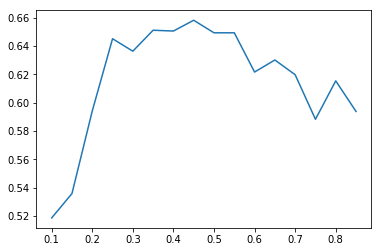

In [230]:
plt.plot(tresh, scores_mouth)

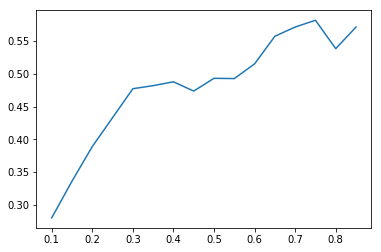

In [231]:
plt.plot(tresh, scores_smile)